# Word Cloud Prototypes | Team Enron Vizards

### Course: W209 - Section 5
### Author: Akiko Iwamizu

---------------------------------------

## About The Data

Provided by [Kaggle Link](https://www.kaggle.com/datasets/wcukierski/enron-email-dataset), the Enron email dataset contains approximately 500,000 emails generated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse.

We conducted basically data preparation and manipulation before beginning EDA. These steps are not included in this notebook, but can be found in our team repo in [GitHub](https://github.com/akikoiwamizu/enron-vizards).

We begin the exploratory data analysis by importing the required libraries and the cleaned dataset.

In [61]:
import altair as alt
import nltk
import pandas as pd
import os
import re
import numpy as np

from ast import literal_eval
from matplotlib import pyplot as plt
from ipywidgets import widgets, interact, interactive, fixed
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer as stemmer
from nltk.stem import WordNetLemmatizer as lemmatizer
from nltk import pos_tag

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)

alt.data_transformers.disable_max_rows()

nltk.download("punkt") # necessary for tokenization
nltk.download("wordnet") # necessary for lemmatization
nltk.download("stopwords") # necessary for removal of stop words
nltk.download("averaged_perceptron_tagger") # necessary for POS tagging
nltk.download("maxent_ne_chunker" ) # necessary for entity extraction
nltk.download("words")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/akikoiwamizu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akikoiwamizu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akikoiwamizu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/akikoiwamizu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/akikoiwamizu/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/akikoiwamizu/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
print(os.listdir("../../data"))

['.DS_Store', 'Enron_data_cleansing_colab.ipynb', 'key_players_clean.csv', 'emails_clean.csv', '.ipynb_checkpoints']


In [3]:
df = pd.read_csv("../../data/emails_clean.csv", 
                 converters=
                 {
                     "X-From": literal_eval,
                     "X-To": literal_eval,
                     "X-cc": literal_eval,
                     "X-bcc": literal_eval
                 }
)
df.shape

/var/folders/xb/9fwt2pnd54b42m6d49kws_qm0000gn/T/ipykernel_31407/2170182621.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../data/emails_clean.csv",


(517092, 21)

After loading in the cleaned dataset, let's take a look at the initial dataframe.

In [4]:
df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,Body,Cc,Bcc,Time,Attendees,Re,day,month,year,time,tzdiff
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,NaN,[Phillip K Allen],[Tim Belden],[],[],"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,Here is our forecast\n\n,NaN,NaN,NaN,NaN,NaN,14,5,2001,16:39:00,-700
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,[Phillip K Allen],[John J Lavorato],[],[],"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,Traveling to have a business meeting takes the...,NaN,NaN,NaN,NaN,NaN,4,5,2001,13:51:00,-700
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,[Phillip K Allen],[Leah Van Arsdall],[],[],\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,test successful. way to go!!!,NaN,NaN,NaN,NaN,NaN,18,10,2000,03:00:00,-700
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,NaN,[Phillip K Allen],[Randall L Gay],[],[],\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,"Randy,\n\n Can you send me a schedule of the s...",NaN,NaN,NaN,NaN,NaN,23,10,2000,06:13:00,-700
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,[Phillip K Allen],[Greg Piper],[],[],\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,Let's shoot for Tuesday at 11:45.,NaN,NaN,NaN,NaN,NaN,31,8,2000,05:07:00,-700


### Adding useful date dimensions

In [5]:
# Create date/time fields that we will need for this viz
df["hour"] = pd.to_datetime(df["time"]).dt.hour.values
df["date_clean"] = pd.to_datetime(df[["year", "month", "day"]])
df["weekday"] = pd.to_datetime(df["date_clean"]).dt.day_name()

### Standardize names

In [6]:
df_clean = df.copy()

# Email authors
authors = pd.Series([item for row in df_clean["X-From"] for item in row if item])
authors = authors.apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())
authors = pd.DataFrame({"name": authors.value_counts().index,
                        "sent": authors.value_counts()}).reset_index(drop=True).sort_values(by="sent", ascending=False)

# Email recipients
all_recipients = df_clean["X-To"] + df_clean["X-cc"] + df_clean["X-bcc"]
recipients = pd.Series([item for row in all_recipients for item in row if item])
recipients = recipients.apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())
recipients = pd.DataFrame({"name": recipients.value_counts().index,
                           "received": recipients.value_counts()}).reset_index(drop=True).sort_values(by="received", ascending=False)


In [7]:
# Standardize all name variations for the key players in the scandal
andrew_fastow = authors.name[authors.name.apply(lambda x: "Andrew S Fastow" in x)]
arthur_andersen = authors.name[authors.name.apply(lambda x: "Arthur Andersen" in x)]
jeff_skilling = authors.name[authors.name.apply(lambda x: "Jeff Skilling" in x)]
ken_lay = authors.name[authors.name.apply(lambda x: "Ken Lay" in x)]
sherron_watkins = authors.name[authors.name.apply(lambda x: "Sherron Watkins" in x)]


In [8]:
# Clean dataset with correct names
def clean_names(name_list):
    for i, name in enumerate(name_list):
        if name in andrew_fastow:
            name_list[i] = "Andrew Fastow"
        elif name in arthur_andersen:
            name_list[i] = "Arthur Andersen"
        elif name in jeff_skilling:
            name_list[i] = "Jeff Skilling"
        elif name in ken_lay:
            name_list[i] = "Kenneth Lay"
        elif name in sherron_watkins:
            name_list[i] = "Sherron Watkins"
        return name_list
    

In [9]:
df_clean["X-From"] = df_clean["X-From"].apply(lambda x: clean_names(x))
df_clean["X-To"] = df_clean["X-To"].apply(lambda x: clean_names(x)) 
df_clean["X-cc"] = df_clean["X-cc"].apply(lambda x: clean_names(x)) 
df_clean["X-bcc"] = df_clean["X-bcc"].apply(lambda x: clean_names(x))
df_clean.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,Body,Cc,Bcc,Time,Attendees,Re,day,month,year,time,tzdiff,hour,date_clean,weekday
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,NaN,[Phillip K Allen],[Tim Belden],[],[],"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,Here is our forecast\n\n,NaN,NaN,NaN,NaN,NaN,14,5,2001,16:39:00,-700,16,2001-05-14,Monday
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,[Phillip K Allen],[John J Lavorato],[],[],"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,Traveling to have a business meeting takes the...,NaN,NaN,NaN,NaN,NaN,4,5,2001,13:51:00,-700,13,2001-05-04,Friday
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,[Phillip K Allen],[Leah Van Arsdall],[],[],\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,test successful. way to go!!!,NaN,NaN,NaN,NaN,NaN,18,10,2000,03:00:00,-700,3,2000-10-18,Wednesday
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,NaN,[Phillip K Allen],[Randall L Gay],[],[],\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,"Randy,\n\n Can you send me a schedule of the s...",NaN,NaN,NaN,NaN,NaN,23,10,2000,06:13:00,-700,6,2000-10-23,Monday
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,[Phillip K Allen],[Greg Piper],[],[],\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,Let's shoot for Tuesday at 11:45.,NaN,NaN,NaN,NaN,NaN,31,8,2000,05:07:00,-700,5,2000-08-31,Thursday


### Create a data subset for only the scandal period (2001-)

In [10]:
# Create subsets of the email dataset before and after the scandal period
after_scandal_period = df_clean[df_clean["date_clean"] >= "2001-09-01"]
before_scandal_period = df_clean[df_clean["date_clean"] < "2001-09-01"]

In [11]:
len(after_scandal_period)

123731

In [12]:
len(before_scandal_period)

393361

### Find the most common words in the email messages during the scandal period

In [15]:
# Email authors + their messages
email_messages_after = after_scandal_period[["date_clean", "From", "X-From", "Body"]].reset_index(drop=True)

# Clean up "From" field
email_messages_after["Name"] = email_messages_after["X-From"].str[0]
email_messages_after["Name"] = email_messages_after["Name"].apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())

email_messages_after.head()


,date_clean,From,X-From,Body,Name
0,2001-12-30,pallen70@hotmail.com,[phillip allen],"\n \n>From: ""Greg Thorse"" \n>To: \n>CC: ""Phill...",Phillip Allen
1,2001-12-27,arsystem@mailman.enron.com,[ARSystem],This request has been pending your approval fo...,Arsystem
2,2001-10-18,webmaster@earnings.com,[Earnings.com],"If you cannot read this email, please click he...",Earnings Com
3,2001-10-18,discount@open2win.oi3.net,[Hotel Discounts],"\n[IMAGE] \t\t[IMAGE] \t\n\t\tDear PHILLIP, ...",Hotel Discounts
4,2001-10-18,no.address@enron.com,[Enron Global Technology@ENRON],"\nEarlier this week, Enron Global Technology a...",Enron Global Technology


In [16]:
# Email authors + their messages
email_messages_before = before_scandal_period[["date_clean", "From", "X-From", "Body"]].reset_index(drop=True)

# Clean up "From" field
email_messages_before["Name"] = email_messages_before["X-From"].str[0]
email_messages_before["Name"] = email_messages_before["Name"].apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())

email_messages_before.head()


,date_clean,From,X-From,Body,Name
0,2001-05-14,phillip.allen@enron.com,[Phillip K Allen],Here is our forecast\n\n,Phillip K Allen
1,2001-05-04,phillip.allen@enron.com,[Phillip K Allen],Traveling to have a business meeting takes the...,Phillip K Allen
2,2000-10-18,phillip.allen@enron.com,[Phillip K Allen],test successful. way to go!!!,Phillip K Allen
3,2000-10-23,phillip.allen@enron.com,[Phillip K Allen],"Randy,\n\n Can you send me a schedule of the s...",Phillip K Allen
4,2000-08-31,phillip.allen@enron.com,[Phillip K Allen],Let's shoot for Tuesday at 11:45.,Phillip K Allen


In [17]:
# Load spacy
import re
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy

nlp = spacy.load('en_core_web_sm')

def clean_string(text, stem="None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', ' ', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ["im", "cc", "subject", "re", "na", "original", "message", "image", "email", "address"]

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [18]:
# Next apply the clean_string function to the text
email_messages_after["Body_Clean"] = email_messages_after["Body"].apply(lambda x: clean_string(x, stem='Lem'))
email_messages_before["Body_Clean"] = email_messages_before["Body"].apply(lambda x: clean_string(x, stem='Lem'))

In [47]:
email_messages_after["Scandal_Period"] = True

In [48]:
email_messages_after.head()

,date_clean,From,X-From,Body,Name,Body_Clean,Scandal_Period
0,2001-12-30,pallen70@hotmail.com,[phillip allen],"\n \n>From: ""Greg Thorse"" \n>To: \n>CC: ""Phill...",Phillip Allen,greg thorse phillip allen bishop corner date s...,True
1,2001-12-27,arsystem@mailman.enron.com,[ARSystem],This request has been pending your approval fo...,Arsystem,request pending approval day please click re...,True
2,2001-10-18,webmaster@earnings.com,[Earnings.com],"If you cannot read this email, please click he...",Earnings Com,cannot read please click earningscom news ear...,True
3,2001-10-18,discount@open2win.oi3.net,[Hotel Discounts],"\n[IMAGE] \t\t[IMAGE] \t\n\t\tDear PHILLIP, ...",Hotel Discounts,dear phillip congratulation get hotel discoun...,True
4,2001-10-18,no.address@enron.com,[Enron Global Technology@ENRON],"\nEarlier this week, Enron Global Technology a...",Enron Global Technology,earlier week enron global technology announced...,True


In [49]:
email_messages_before["Scandal_Period"] = False

In [50]:
email_messages_before.head()

,date_clean,From,X-From,Body,Name,Body_Clean,Scandal_Period
0,2001-05-14,phillip.allen@enron.com,[Phillip K Allen],Here is our forecast\n\n,Phillip K Allen,forecast,False
1,2001-05-04,phillip.allen@enron.com,[Phillip K Allen],Traveling to have a business meeting takes the...,Phillip K Allen,traveling business meeting take fun trip espec...,False
2,2000-10-18,phillip.allen@enron.com,[Phillip K Allen],test successful. way to go!!!,Phillip K Allen,test successful way go,False
3,2000-10-23,phillip.allen@enron.com,[Phillip K Allen],"Randy,\n\n Can you send me a schedule of the s...",Phillip K Allen,randy send schedule salary level everyone sche...,False
4,2000-08-31,phillip.allen@enron.com,[Phillip K Allen],Let's shoot for Tuesday at 11:45.,Phillip K Allen,let shoot tuesday,False


In [22]:
# Export snapshot of data + compress
compression_opts = dict(method='zip', archive_name='email_messages_before.csv')  
email_messages_before.to_csv('email_messages_before.zip', index=False, compression=compression_opts)  

In [23]:
# Export snapshot of data + compress
compression_opts = dict(method='zip', archive_name='email_messages_after.csv')  
email_messages_after.to_csv('email_messages_after.zip', index=False, compression=compression_opts)  

In [54]:
result = pd.concat([email_messages_before, email_messages_after])
result = result[["date_clean", "Name", "Body_Clean", "Scandal_Period"]].reset_index(drop=True)
result.drop_duplicates()
result.head()

,date_clean,Name,Body_Clean,Scandal_Period
0,2001-05-14,Phillip K Allen,forecast,False
1,2001-05-04,Phillip K Allen,traveling business meeting take fun trip espec...,False
2,2000-10-18,Phillip K Allen,test successful way go,False
3,2000-10-23,Phillip K Allen,randy send schedule salary level everyone sche...,False
4,2000-08-31,Phillip K Allen,let shoot tuesday,False


In [55]:
len(result)

517092

In [56]:
# Export snapshot of data + compress
compression_opts = dict(method='zip', archive_name='result.csv')  
result.to_csv('result.zip', index=False, compression=compression_opts)  

In [58]:
# Export snapshot of data + compress
result.to_parquet('result.parquet.gzip', compression='gzip')  

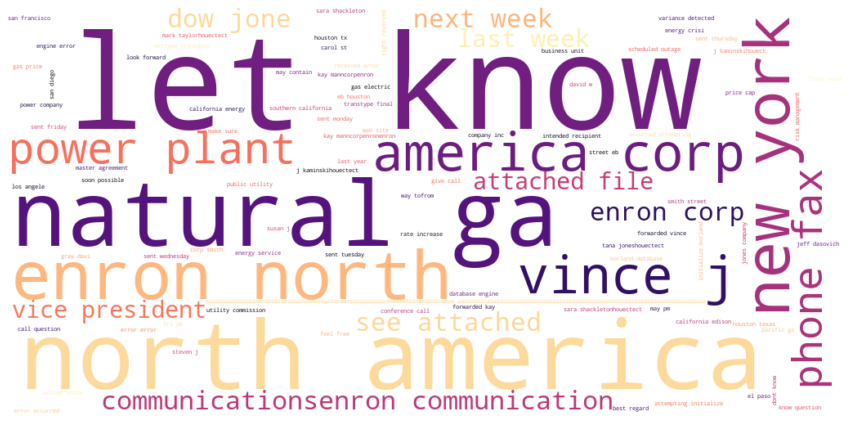

<Figure size 432x288 with 0 Axes>

In [26]:
%matplotlib inline

text = " ".join(item for item in email_messages_before["Body_Clean"])

# Remove stopwords
stopwords = set(STOPWORDS)
stopwords.update(["please", "hi", "im", "ill", "cc", "subject", "re", "na", "original", "message", "image", "email", "address"])

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white", 
                      max_words=100,
                      width=1024, 
                      height=500,
                      colormap="magma"                      
                     ).generate(text)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
plt.savefig("cloud_after.png")

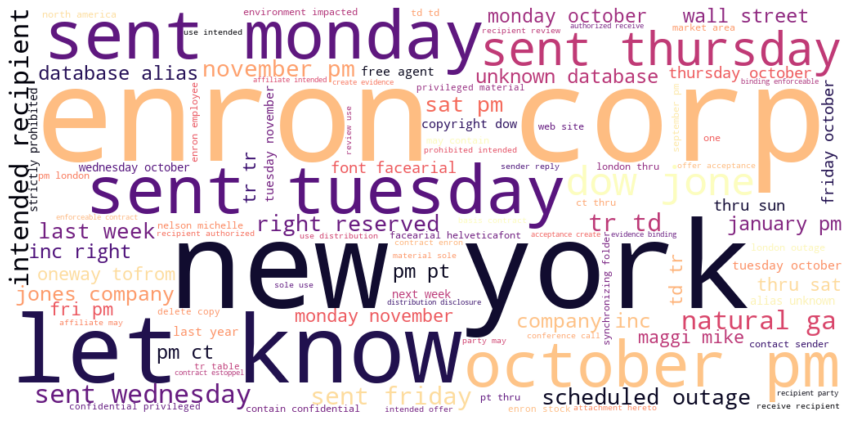

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline

text = " ".join(item for item in email_messages_after["Body_Clean"])

# Remove stopwords
stopwords = set(STOPWORDS)
stopwords.update(["please", "hi", "im", "ill", "cc", "subject", "re", "na", "original", "message", "image", "email", "address"])

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white", 
                      max_words=100,
                      width=1024, 
                      height=500,
                      colormap="magma"                      
                     ).generate(text)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
plt.savefig("cloud_before.png")

### Create a subset of the email data to include only the key players of the scandal

In [38]:
key_names = ["Andrew Fastow", "Jeff Skilling", "Kenneth Lay", "Sherron Watkins"]

In [39]:
# Email authors + their messages
key_players_before = email_messages_before[["date_clean", "From", "X-From", "Body"]].reset_index(drop=True)

# Clean up "From" field
key_players_before["Name_From"] = key_players_before["X-From"].str[0]
#key_players["Name_To"] = key_players["X-To"].str[0]
key_players_before["Name_From"] = key_players_before["Name_From"].apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())
#key_players["Name_To"] = key_players["Name_To"].apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())


In [62]:
# Create a subset of email messages from key players in the scandal
key_players_before = key_players_before[["date_clean", "Name_From", "Body"]]
key_players_before["Body_Clean"] = key_players_before["Body"].apply(lambda x: clean_string(x, stem='Lem'))
key_players_before = key_players_before.loc[key_players_before["Name_From"].isin(key_names)].reset_index(drop=True)
key_players_before.drop_duplicates()
len(key_players_before)


142

In [41]:
key_players_before.head()

,date_clean,Name_From,Body,Body_Clean
0,2001-08-23,Kenneth Lay,\n\nTo:\tAssociate/Analyst Program Worldwide\...,associateanalyst program worldwide ken lay dep...
1,2001-08-23,Kenneth Lay,\n\nTo:\tAssociate/Analyst Program Worldwide\...,associateanalyst program worldwide ken lay dep...
2,2001-08-08,Jeff Skilling,Dear Enron Employees:\n\nI am saddened to info...,dear enron employee saddened inform explosion ...
3,2001-08-14,Sherron Watkins,"Rick, \n\nLynn recently demo'd portrac for all...",rick lynn recently demod portrac u corp develo...
4,2001-08-14,Sherron Watkins,Wow - you are really busy if your lunch calend...,wow really busy lunch calendar booked remainde...


In [42]:
# Email authors + their messages
key_players_after = email_messages_after[["date_clean", "From", "X-From", "Body"]].reset_index(drop=True)

# Clean up "From" field
key_players_after["Name_From"] = key_players_after["X-From"].str[0]
#key_players["Name_To"] = key_players["X-To"].str[0]
key_players_after["Name_From"] = key_players_after["Name_From"].apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())
#key_players["Name_To"] = key_players["Name_To"].apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())


In [43]:
# Create a subset of email messages from key players in the scandal
key_players_after = key_players_after[["date_clean", "Name_From", "Body"]]
key_players_after["Body_Clean"] = key_players_after["Body"].apply(lambda x: clean_string(x, stem='Lem'))
key_players_after = key_players_after.loc[key_players_after["Name_From"].isin(key_names)].reset_index(drop=True)
key_players_after.drop_duplicates()
len(key_players_after)


21

In [44]:
key_players_after.head()

,date_clean,Name_From,Body,Body_Clean
0,2001-09-27,Sherron Watkins,\n\tIn August we were discussing the additiona...,august discussing additional information need ...
1,2001-09-27,Sherron Watkins,Take a look at these pics! For anyone who has ...,take look pic anyone worked visited wtc area p...
2,2001-11-19,Sherron Watkins,"Michelle, I have talked to Steven Sheldon, Mar...",michelle talked steven sheldon martin sacchi s...
3,2001-12-02,Kenneth Lay,"fyi\n-----Original Message-----\nFrom: Oxley, ...",fyi oxley binkley sent sunday december pm l...
4,2001-10-30,Sherron Watkins,"I forgot to print out this page, this is the p...",forgot print page page reviewed lay sherron w...


In [63]:
# Email authors + their messages
key_players = df_clean[["date_clean", "From", "X-From", "X-To", "Body"]].reset_index(drop=True)

# Clean up "From" field
key_players["Name_From"] = key_players["X-From"].str[0]
key_players["Name_To"] = key_players["X-To"].str[0]
key_players["Name_From"] = key_players["Name_From"].apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())
key_players["Name_To"] = key_players["Name_To"].apply(lambda x: x.split("@")[0].replace("\"", "").replace("'", "").replace(".", " ").replace("_", " ").strip().title())
key_players.head()


,date_clean,From,X-From,X-To,Body,Name_From,Name_To
0,2001-05-14,phillip.allen@enron.com,[Phillip K Allen],[Tim Belden],Here is our forecast\n\n,Phillip K Allen,Tim Belden
1,2001-05-04,phillip.allen@enron.com,[Phillip K Allen],[John J Lavorato],Traveling to have a business meeting takes the...,Phillip K Allen,John J Lavorato
2,2000-10-18,phillip.allen@enron.com,[Phillip K Allen],[Leah Van Arsdall],test successful. way to go!!!,Phillip K Allen,Leah Van Arsdall
3,2000-10-23,phillip.allen@enron.com,[Phillip K Allen],[Randall L Gay],"Randy,\n\n Can you send me a schedule of the s...",Phillip K Allen,Randall L Gay
4,2000-08-31,phillip.allen@enron.com,[Phillip K Allen],[Greg Piper],Let's shoot for Tuesday at 11:45.,Phillip K Allen,Greg Piper


In [72]:
# Create a subset of email messages from key players in the scandal
key_names = ["Andrew Fastow", "Jeff Skilling", "Kenneth Lay", "Sherron Watkins"]

key_players = key_players.loc[key_players["Name_From"].isin(key_names) | 
                              key_players["Name_To"].isin(key_names)].reset_index(drop=True)

key_players["Key_Player"] = key_players.apply(get_key_player_name, axis=1)

key_players["Scandal_Period"] = np.where(key_players["date_clean"] >= "2001-09-01", True, False)

key_players.drop_duplicates()
key_players.head()

,date_clean,Name_From,Name_To,Body,Scandal_Period,Key_Player
0,2000-05-22,John Arnold,Jeff Skilling,Jeff:\nSorry for my cryptic answer in regards ...,False,Jeff Skilling
1,2000-05-22,John Arnold,Jeff Skilling,Jeff:\nSorry for my cryptic answer in regards ...,False,Jeff Skilling
2,2000-05-22,John Arnold,Jeff Skilling,Jeff:\nSorry for my cryptic answer in regards ...,False,Jeff Skilling
3,2000-05-22,John Arnold,Jeff Skilling,Jeff:\nSorry for my cryptic answer in regards ...,False,Jeff Skilling
4,2001-07-14,Iris Mack,Kenneth Lay,"\nDear Dr. Lay,\n\n\tMy name is Iris Mack. My...",False,Kenneth Lay


In [71]:
def get_key_player_name(df):
    if df["Name_From"] == "Jeff Skilling" or df["Name_To"] == "Jeff Skilling":
        return "Jeff Skilling"
    elif df["Name_From"] == "Kenneth Lay" or df["Name_To"] == "Kenneth Lay":
        return "Kenneth Lay"
    elif df["Name_From"] == "Andrew Fastow" or df["Name_To"] == "Andrew Fastow":
        return "Andrew Fastow"
    elif df["Name_From"] == "Sherron Watkins" or df["Name_To"] == "Sherron Watkins":
        return "Sherron Watkins"
    else:
        return "Other"

In [76]:
# Next apply the clean_string function to the text
key_players["Body_Clean"] = key_players["Body"].apply(lambda x: clean_string(x, stem='Lem'))
key_players = key_players[["date_clean", "Key_Player", "Body_Clean", "Scandal_Period"]]

3434

In [81]:
key_players_clean = key_players.drop_duplicates(keep=False).reset_index(drop=True)
len(key_players_clean)

1260

In [82]:
key_players_clean.head(-100)

,date_clean,Key_Player,Body_Clean,Scandal_Period
0,2001-07-14,Kenneth Lay,dear dr lay name iris mack former bos vince ka...,False
1,2001-09-27,Sherron Watkins,august discussing additional information need ...,True
2,2001-09-27,Sherron Watkins,take look pic anyone worked visited wtc area p...,True
3,2001-10-17,Andrew Fastow,plan hold special meeting enron corp board dir...,True
4,2002-01-11,Kenneth Lay,please advised copy congressional subpoena iss...,True
...,...,...,...,...
1155,2001-04-20,Jeff Skilling,jeff excellent job deal give u nod anxious exp...,False
1156,2001-04-20,Jeff Skilling,mr skilling rev lawson would like thank extend...,False
1157,2001-04-20,Jeff Skilling,pledge serum sherri behalf skilling jeff sent...,False
1158,2001-04-20,Jeff Skilling,dear jeff would personally like invite year co...,False


In [ ]:
test = key_players["Body_Clean"].str.split(expand=True).stack().value_counts().reset_index()
test.columns = ["Word", "Count"]
test.head()

In [83]:
# Export snapshot of data + compress
compression_opts = dict(method='zip', archive_name='key_players_clean.csv')  
key_players_clean.to_csv('key_players_clean.zip', index=True, compression=compression_opts)  

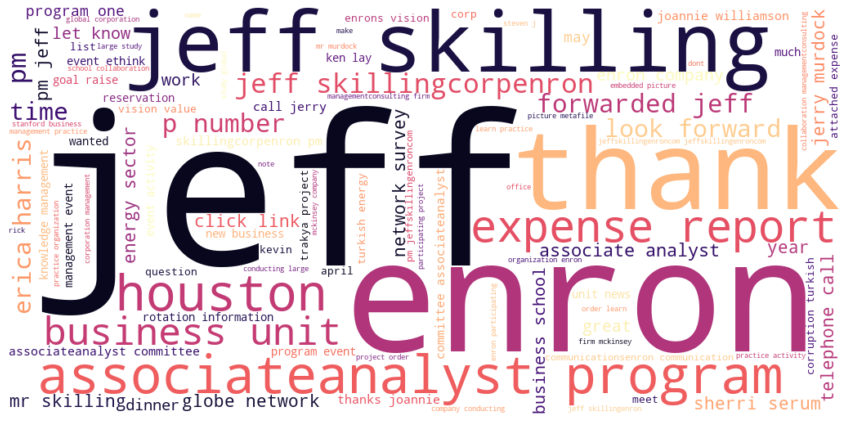

<Figure size 432x288 with 0 Axes>

In [45]:
%matplotlib inline
text = " ".join(item for item in key_players_before["Body_Clean"])

stopwords = set(STOPWORDS)
stopwords.update(["jeffskillinenroncom", "u", "skillingcorpenronenron", "please", "hi", "im", "ill", "cc", "subject", "re", "na", "original", "message", "image", "email", "address"])

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white", 
                      max_words=100,
                      width=1024, 
                      height=500,
                      colormap="magma"                      
                     ).generate(text)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
plt.savefig("cloud_key_players.png")

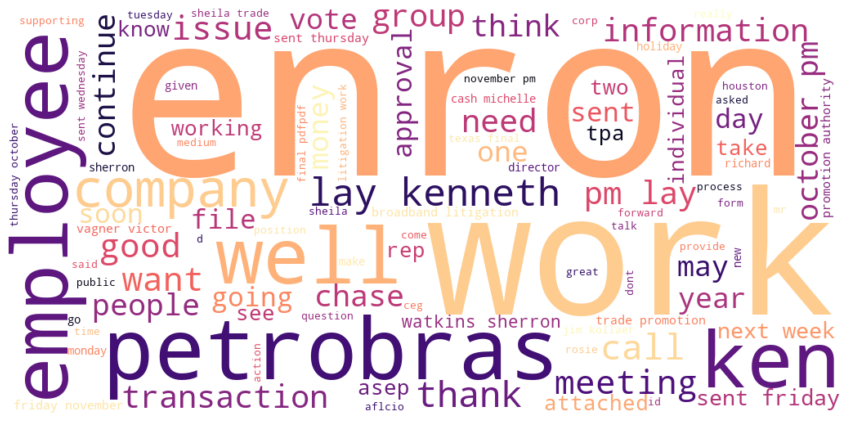

<Figure size 432x288 with 0 Axes>

In [46]:
%matplotlib inline
text = " ".join(item for item in key_players_after["Body_Clean"])

stopwords = set(STOPWORDS)
stopwords.update(["jeffskillinenroncom", "u", "skillingcorpenronenron", "please", "hi", "im", "ill", "cc", "subject", "re", "na", "original", "message", "image", "email", "address"])

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white", 
                      max_words=100,
                      width=1024, 
                      height=500,
                      colormap="magma"                      
                     ).generate(text)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
plt.savefig("cloud_key_players.png")

To improve the visualization, let's allow users to interactively select the key players in the scandal and see how their word clouds change.

In [ ]:
%matplotlib notebook
def clean_emails(Employee, frame, col):
    newframe=frame.copy()  
    newframe[col] = newframe[col].str.replace('\d+', "", regex=True).str.replace("?", "", regex=True).str.replace('\W', " ", regex=True).str.lower()
    newframe = newframe[newframe["Name"]==Employee].astype(str)
    
    text = " ".join(newframe[col][:])
    pattern = re.compile(r'\b(' + r'|'.join(set(STOPWORDS)) + r')\b\s*')
    cleantext = pattern.sub("", text)
    
    text_tokenized = cleantext.split(" ")
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text_tokenized if word != ""]
    cloudtext = " ".join(words)
    
    return cloudtext

def make_clouds(Employee, frame, col, Maximum, title):
    cloudtext = clean_emails(Employee, frame, col)
    wordcloud = WordCloud(max_font_size=40, max_words=Maximum, background_color="white", collocations=False).generate(cloudtext)
    wordcloud.generate_from_frequencies
    
    plt.style.use("tableau-colorblind10")
    plt.figure(figsize=(10,10))
    plt.title(title, fontsize=18, fontweight="bold")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
cloud = interact(make_clouds, 
         Employee=key_players,
         Maximum=[100, 75, 50, 25],
         df=fixed(email_messages_kp), 
         col=fixed("Body"), 
         title=fixed("\nMost Common Words in Emails by the Enron Scandal Key Players\n"),
         frame=fixed(email_messages_kp[["Name","Body"]])
        )


#### Conclusion: 

These data views suggest that the most common words used by key players in their emails vary quite a bit depending on the employee. Across all the key players, there are various greetings and meeting times like the key player's names and "Monday" or "pm" likely for scheduling purposes, but there are also many common words like "enronxgate", "investigation", and various references to internal initiatives like the petrobas gas initiative. 

---------------------------------------